In [1]:
from PIL import Image
import numpy as np
import math
import collections 
import matplotlib.pyplot as plt

# Tell numpy to print numbers to 4 decimal places only
np.set_printoptions(precision=4, suppress=True)

In [2]:
## global variable
maxPixel = 255 ##for gray level image

def img2matrix(img):
    return np.asarray(img).copy()
def matrix2img(matrix):
    return Image.fromarray(matrix).convert("L")

def showImg(originalImg,newImg,new_title="new Image",original_title = "original Image"):
    fig = plt.figure(figsize=(15,15))
    fig1 = fig.add_subplot(121)
    fig2 = fig.add_subplot(122)
    fig1.imshow(originalImg,cmap="gray")
    fig2.imshow(newImg,cmap="gray")
    fig1.title.set_text(original_title)
    fig2.title.set_text(new_title)
    plt.show()

In [3]:
def binaryImg(img,threshold= 127): # floor(255/2)
    imgMatrix = img2matrix(img)   
    for i in range(imgMatrix.shape[0]):
        for j in range(imgMatrix.shape[1]):
            if imgMatrix[i][j] > threshold:
                imgMatrix[i][j] = 255
            else:
                imgMatrix[i][j] = 0
                
    return matrix2img(imgMatrix)


In [4]:
def convolution(matrix,mask,origin=(0,0)):
    newMatrix = np.arange(np.size(matrix)).reshape(matrix.shape[0],matrix.shape[1])

    for row in range(matrix.shape[0]):
            for col in range(matrix.shape[1]):  # 1,1 --> (1,1)
    
                newPix = 0
                outOfBound = False
                for x in range(mask.shape[0]):
                    for y in range(mask.shape[1]):
                        try: # exception handling for index out of bound
                            
                            if (row+x-origin[0]) < 0:
                                raise Exception
                            else:
                                newPix += int(matrix[row+x-origin[0]][col+y-origin[1]]) * mask[x][y]

                        except Exception as e:
                            outOfBound = True
                            break;
                        finally:
                            pass
                    if outOfBound == True:
                        break;
                        
                if  outOfBound == False:
                    newMatrix[row][col] = int(newPix)
                else:
                    newMatrix[row][col] = matrix[row][col]
                    
                 
                    
    return newMatrix

In [5]:
def removeSmallDetails(image,bgPix = 255 ,objPix =0 ,size=(3,3)): # size of the filter 
        matrix = img2matrix(image)
        Xs = int(size[0]/2)
        Ys = int(size[1]/2)
         
        for X in range(Xs,matrix.shape[0]-Xs):
            for Y in range(Ys,matrix.shape[1]-Ys):
                
                if matrix[X][Y] == objPix:
                    try:
                        #X,Y is the center of the filter
                        isSmallDetail = True # is isolated point    
                        #scan top and bottom row
                        for col in range(Y-Ys,Y+Ys+1):
                            #rows                                  
                            if(matrix[X-Xs][col] != bgPix) or (matrix[X+Xs][col] != bgPix):
                                isSmallDetail = False
                                break;
                    
                        if (isSmallDetail == True):  
                            
                            #scan first and last columns
                            for row in range(X-Xs+1,X+Xs):

                                if ( matrix[row][Y-Ys] != bgPix) or  (matrix[row][Y+Ys] != bgPix ):
                                        isSmallDetail = False
                                        break;
                     
                        if isSmallDetail == True:
                            #change all the pixel of the isolated point into bgpixels
                            for i in range(X-Xs+1,X+Xs):
                                for j in range(Y-Ys+1,Y+Ys):
                                    matrix[i][j] = bgPix
                                   
                    except Exception as e:
                        pass
        return matrix2img(matrix)
#         return matrix


In [6]:
def laplacian_filter(image):
    imgMatrix = img2matrix(image)
    #LoG mask
    mask = np.array([
                        [0,0,3,2,2,2,3,0,0],
                        [0,2,3,5,5,5,3,2,0],
                        [3,3,5,3,0,3,5,3,3],
                        [2,5,3,-12,-23,-12,3,5,2],
                        [2,5,0,-23,-40,-23,0,5,2],
                        [2,5,3,-12,-23,-12,3,5,2],
                        [3,3,5,3,0,3,5,3,3],
                        [0,2,3,5,5,5,3,2,0],
                        [0,0,3,2,2,2,3,0,0],
                                                ])
    
    # applying convolution 
    newMatrix = convolution(imgMatrix,mask,(4,4))
    
    # thresholding 
    for row in range(newMatrix.shape[0]):
        for col in range(newMatrix.shape[1]):
            if newMatrix[row][col] < 0 :
                newMatrix[row][col] = 0
            else:
                newMatrix[row][col] = 255
            
   
    return matrix2img(newMatrix)
    

In [7]:
def isConnected(matrix,x,y,bgPix= 2000 ): #check four connected
    if matrix[x][y-1] == matrix[x-1][y]== bgPix: #not connected
        return 0
    elif (matrix[x][y-1]== matrix[x][y]) and (matrix[x-1][y] == matrix[x][y] ): #fully connected
        return 1
    elif (matrix[x][y-1]== bgPix) ^ (matrix[x-1][y] == bgPix): # not conflict
        return 2
    else: #conflict
        return 3 

#---------------------------------------------------------------------------------------------------
def getEquivalentPix(eqList,pixValue):
    if eqList[pixValue] != pixValue :
        pixValue = getEquivalentPix(eqList,eqList[pixValue])
    return pixValue
#-----------------------------------------------------------------------------------------------------
 
    
def labelConnectedComponents(matrix,bgPix = 2000 ,objPix=0):
#     imgMatrix = img2matrix(image) 
    imgMatrix = matrix
    equivalencyList = []
    label = -1
    for row in range(1,imgMatrix.shape[0]):
        for col in range(1,imgMatrix.shape[1]):
            if imgMatrix[row][col] != bgPix:
                if isConnected(imgMatrix,row,col) == 0:
                        label += 1    
#                         equivalencyList.append({"label":label,"equivalent":label})
                        equivalencyList.append(label) # index == pixLable and label == equivalent pixLable
                                                     # for eg, label[1] = 2 ,  1 -> 2 , 1 equivalent to 2
                        imgMatrix[row][col] = label
                elif isConnected(imgMatrix,row,col) == 1:
                    imgMatrix[row][col] = imgMatrix[row][col-1] 
                    
                elif isConnected(imgMatrix,row,col) == 2:
                
                    imgMatrix[row][col] = min(imgMatrix[row][col-1] , imgMatrix[row-1][col])
                    
                else : # conflict
                    try:
                        newLabel = min(imgMatrix[row][col-1] , imgMatrix[row-1][col]) 
                        equPix  = max(imgMatrix[row][col-1] , imgMatrix[row-1][col]) 
                        imgMatrix[row][col] = newLabel
                        equivalencyList[equPix] = newLabel
                    
                    except Exception as e:
                        pass
                    
                    
#     print("equivalencyList")
#     for i in range(len(equivalencyList)):
#         print(f"{i}-->{equivalencyList[i]}")
        
    #perform scan to apply equivalent pixels
    for row in range(imgMatrix.shape[0]):
        for col in range(imgMatrix.shape[1]):
            if imgMatrix[row][col] != bgPix:
                imgMatrix[row][col] = getEquivalentPix(equivalencyList,imgMatrix[row][col])
    
    return imgMatrix

#----------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------

def getIndex(labelsList,Label): # return the index where label is equals to Label 
    for index,item in enumerate(labelsList):
        if item["label"] == Label:
            return(index)
        
        
def getLabelsCoordinates(matrix , bgPix = 255):
    labelsCoordinates = {"paths":[]}
    addedPixels = []

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            pix = matrix[i][j]
            if pix != bgPix:
                if (pix not in addedPixels):
                    labelsCoordinates["paths"].append({"label" : pix ,"coordinates" :[[int(i),int(j)]]})
                    addedPixels.append(pix)
                else:

                    index = getIndex(labelsCoordinates["paths"],pix)
                    labelsCoordinates["paths"][index]["coordinates"].append([int(i),int(j)])

    return labelsCoordinates


In [8]:
# change 255 value to 2000

def encodeBackgroundPix(matrix,bgPix = 255,encodingValue=2000): # encodingValue  is a new temp pix value
        newMatrix = np.full((matrix.shape[0],matrix.shape[1]),encodingValue)
        
        for row in range(newMatrix.shape[0]):
            for col in range(newMatrix.shape[1]):
                if matrix[row][col] != bgPix :
                    newMatrix[row][col]  = matrix[row][col]
        return newMatrix

def decodingBackgroundPix(matrix,bgPix = 255 , encodingValue  = 2000):
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            if matrix[row][col]  == encodingValue:
                matrix[row][col]  = bgPix
    
    return matrix
    

def convertIntoBinary(matrix,bgPix = 255):
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            if matrix[row][col]  != bgPix:
                matrix[row][col]  = 0
    
    return matrix
    
# eMatrix  = encodeBackgroundPix(matrix)
# decodingBackgroundPix(eMatrix)


# Working on Matrix

In [9]:
# test canvas for matrix
from ipycanvas import Canvas

def drawMatrix(matrix,labelsCoordinates):
    
    canvas = Canvas(width = matrix.shape[1] , height= matrix.shape[0])
    canvas.begin_path()
  
    for item in labelsCoordinates:
        canvas.move_to(item["coordinates"][0][1],item["coordinates"][0][0])
        for pos in item["coordinates"]:
            canvas.line_to(pos[1], pos[0])

        canvas.stroke()

    return canvas


In [56]:
matrix = np.full((100,100),255)
np.random.seed(1)
# for i in range(1,matrix.shape[0]):
#     for j in range(1,matrix.shape[1]):
#         if np.random.random() < 0.6:
#             matrix[i][j] = 0

for i in range(50,60):
    for j in range(1,matrix.shape[1]):
            matrix[i][j] = 0



print(matrix)

matrix = encodeBackgroundPix(matrix)
matrixImg = labelConnectedComponents(matrix)
print("------------")
# connectedList = getLabelsCoordinates(img2matrix(matrixImg))
connectedList = getLabelsCoordinates(matrixImg,2000)
print(matrixImg)
matrixImg = decodingBackgroundPix(matrixImg)
print(matrixImg)
connectedList

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
------------
[[2000 2000 2000 ... 2000 2000 2000]
 [2000 2000 2000 ... 2000 2000 2000]
 [2000 2000 2000 ... 2000 2000 2000]
 ...
 [2000 2000 2000 ... 2000 2000 2000]
 [2000 2000 2000 ... 2000 2000 2000]
 [2000 2000 2000 ... 2000 2000 2000]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


{'paths': [{'label': 0,
   'coordinates': [(50, 1),
    (50, 2),
    (50, 3),
    (50, 4),
    (50, 5),
    (50, 6),
    (50, 7),
    (50, 8),
    (50, 9),
    (50, 10),
    (50, 11),
    (50, 12),
    (50, 13),
    (50, 14),
    (50, 15),
    (50, 16),
    (50, 17),
    (50, 18),
    (50, 19),
    (50, 20),
    (50, 21),
    (50, 22),
    (50, 23),
    (50, 24),
    (50, 25),
    (50, 26),
    (50, 27),
    (50, 28),
    (50, 29),
    (50, 30),
    (50, 31),
    (50, 32),
    (50, 33),
    (50, 34),
    (50, 35),
    (50, 36),
    (50, 37),
    (50, 38),
    (50, 39),
    (50, 40),
    (50, 41),
    (50, 42),
    (50, 43),
    (50, 44),
    (50, 45),
    (50, 46),
    (50, 47),
    (50, 48),
    (50, 49),
    (50, 50),
    (50, 51),
    (50, 52),
    (50, 53),
    (50, 54),
    (50, 55),
    (50, 56),
    (50, 57),
    (50, 58),
    (50, 59),
    (50, 60),
    (50, 61),
    (50, 62),
    (50, 63),
    (50, 64),
    (50, 65),
    (50, 66),
    (50, 67),
    (50, 68),
    (50, 69),
    

# view Image and Canvas

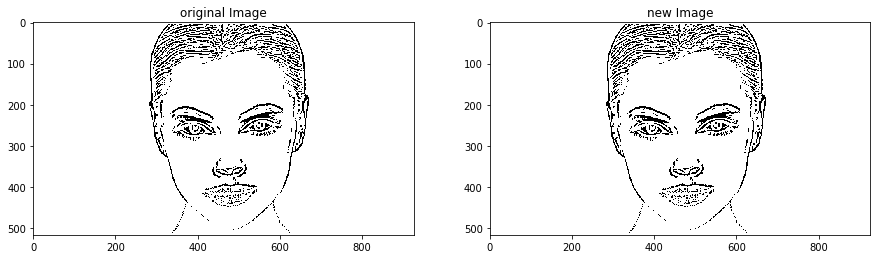

NameError: name 'drawMatrix' is not defined

In [35]:

showImg(matrix,convertIntoBinary(matrixImg))
drawMatrix(matrix,connectedList)

# Working On Image

In [10]:
from ipycanvas import Canvas

def drawImg(matrix,labelsCoordinates):
    canvas = Canvas(width = matrix.shape[1] , height= matrix.shape[0])
    print("drawing")
    canvas.begin_path()
    canvas.stroke_style = "Red"
    count = 0
    for item in labelsCoordinates:
        path = item["coordinates"] 
#         canvas.move_to(item["coordinates"][0][1],item["coordinates"][0][0])
        canvas.move_to(path[0][1],path[0][0])


        for pos in path:
#             print(pos[1], pos[0])
            canvas.line_to(pos[1], pos[0])

        canvas.stroke()
        
#         if count == 5:
#             break;
    
    return canvas

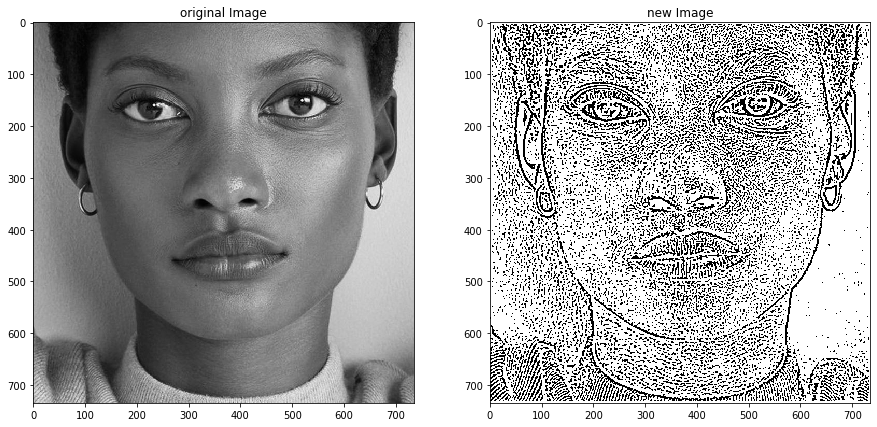

In [26]:
img = Image.open("image_Assets/random-Image/face3.jpg").convert("L")
# dImg = removeSmallDetails(laplacian_filter(img),255,0,size=(7,7))
dImg = laplacian_filter(img)
# dImg = binaryImg(img,100)
showImg(img,dImg)

------------
[[2000 2000 2000 ... 2000 2000 2000]
 [2000 2000 2000 ... 2000 2000 2000]
 [2000 2000 2000 ... 2000 2000 2000]
 ...
 [2000 2000 2000 ... 2000 2000 2000]
 [2000 2000 2000 ... 2000 2000 2000]
 [2000 2000 2000 ... 2000 2000 2000]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


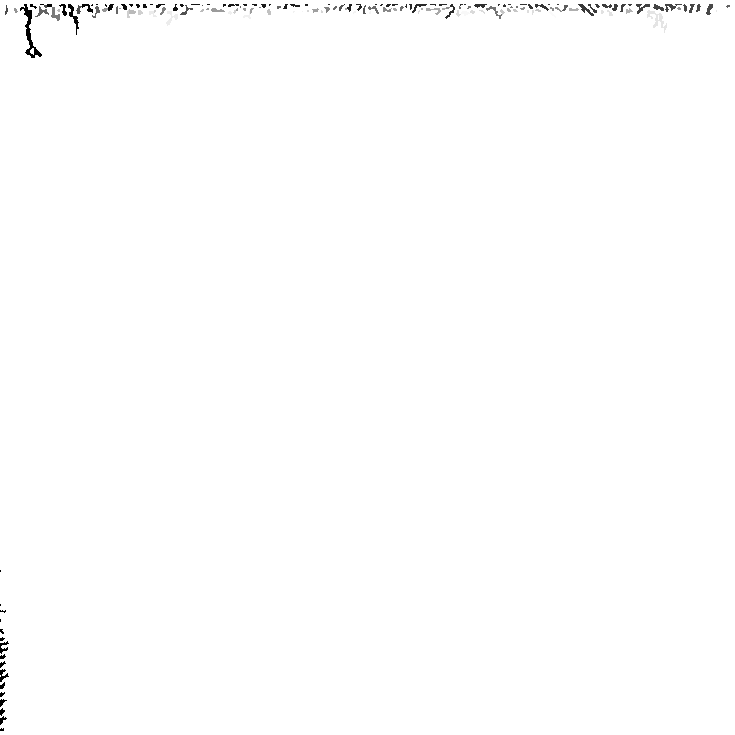

In [28]:
matrix = img2matrix(dImg)
matrix = encodeBackgroundPix(matrix)
matrixImg = labelConnectedComponents(matrix) # label all the connected components
print("------------")
# connectedList = getLabelsCoordinates(img2matrix(matrixImg))
connectedList = getLabelsCoordinates(matrixImg,2000)
print(matrixImg)
matrixImg = decodingBackgroundPix(matrixImg)
print(matrixImg)
matrix2img(matrixImg)
# connectedList

# View Image and Canvas

272 185


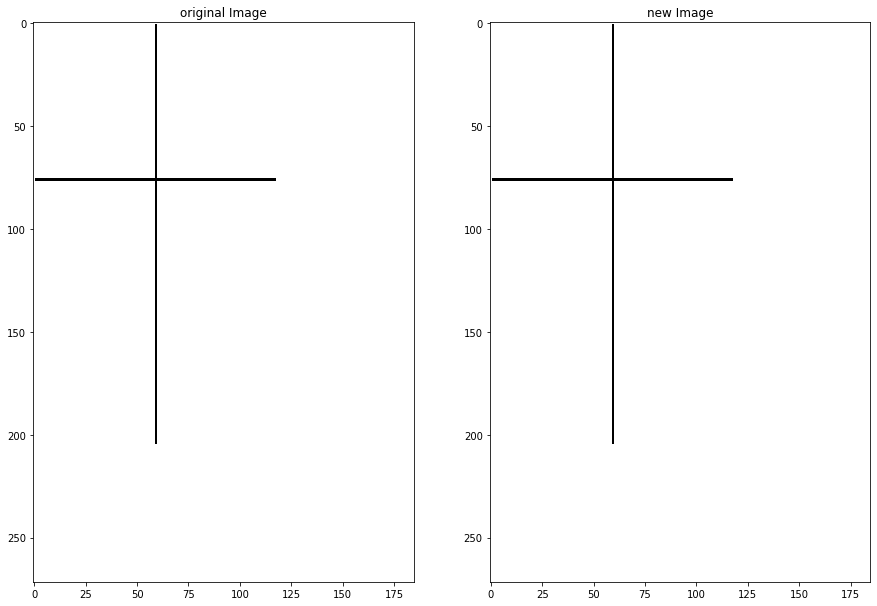

In [97]:
print(matrix.shape[0],matrix.shape[1])
showImg(matrix,convertIntoBinary(matrixImg)) 

In [98]:
canvas = drawImg(matrix,connectedList["paths"])
canvas

drawing


Canvas(height=272, width=185)

In [29]:
#save connectedList into file
import json
# connectedList = {'paths': [
#     {'label': 0, 'coordinates': [[37, 48]]},
#     {'label': 1, 'coordinates': [[73, 254], [74, 254]]}, 
#     {'label': 2, 'coordinates': [[73, 258], [74, 258], [75, 258]]},
#     {'label': 3, 'coordinates': [[75, 255], [76, 255]]},
#     {'label': 4, 'coordinates': [[76, 257], [77, 257]]}, 
#     {'label': 5, 'coordinates': [[78, 256], [79, 256], [80, 256]]}, 
#     {'label': 6, 'coordinates': [[81, 255]]}, 
#     {'label': 8, 'coordinates': [[123, 139], [124, 139]]}, 
#     {'label': 9, 'coordinates': [[123, 143], [124, 142],[125, 142]]}, 
#    {'label': 11, 'coordinates': [[125, 140]]}, 
#    {'label': 12, 'coordinates': [[126, 141], [127, 141]]}, 
#    {'label': 13, 'coordinates': [[128, 140]]}, 
#    {'label': 14, 'coordinates': [[128, 142]]}, 
#    {'label': 15, 'coordinates': [[129, 139]]}, 
#    {'label': 16, 'coordinates': [[129, 143]]}
#      ]}
# connectedListString = json.dumps(connectedList)
print(connectedList)
# with open('connectedList.txt', 'w') as filehandle:
# #     filehandle.writelines("%s,\n" % path for path in connectedList["paths"])
#     filehandle.write(connectedList)

{'paths': [{'label': 0, 'coordinates': [[4, 24], [4, 25], [4, 26], [5, 24], [5, 25], [5, 26], [6, 25], [6, 26], [7, 21], [7, 22], [7, 23], [7, 25], [7, 26], [7, 27], [8, 20], [8, 21], [8, 22], [8, 23], [8, 24], [8, 25], [8, 26], [8, 27], [9, 20], [9, 21], [9, 24], [9, 25], [9, 26], [9, 27], [10, 20], [10, 24], [10, 25], [10, 26], [10, 27], [10, 28], [10, 29], [10, 30], [10, 31], [11, 25], [11, 26], [11, 27], [11, 28], [11, 29], [11, 30], [11, 31], [12, 25], [12, 26], [12, 27], [12, 28], [12, 29], [12, 30], [12, 31], [13, 24], [13, 25], [13, 26], [13, 27], [13, 28], [13, 29], [13, 30], [13, 31], [14, 24], [14, 25], [14, 26], [14, 27], [14, 28], [14, 29], [14, 30], [14, 31], [15, 26], [15, 27], [15, 28], [15, 29], [15, 30], [15, 31], [16, 27], [16, 28], [16, 29], [16, 30], [16, 31], [17, 28], [17, 29], [17, 30], [17, 31], [18, 28], [18, 29], [18, 30], [18, 31], [19, 28], [19, 29], [19, 30], [20, 28], [20, 29], [20, 30], [21, 27], [21, 28], [21, 29], [21, 30], [22, 27], [22, 28], [22, 29]

In [43]:
path = []
path.append({"student" = {"name":"Ram"})

'{"path": [{"label": "Ram", "coordinate": [[1, 2], [3, 4]]}, {"label": "Ram", "coordinate": [[1, 2], [3, 4]]}]}'